### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import os

pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

### Read input files

In [19]:
patient_profile = pd.read_csv('Train/Patient_Profile.csv')
camp_detail = pd.read_csv('Train/Health_Camp_Detail.csv')
first_camp_attended = pd.read_csv('Train/First_Health_Camp_Attended.csv')
second_camp_attended = pd.read_csv('Train/Second_Health_Camp_Attended.csv')
third_camp_attended = pd.read_csv('Train/Third_Health_Camp_Attended.csv')
train = pd.read_csv('Train/train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submmission.csv')

first_camp_attended= first_camp_attended.drop('Unnamed: 4',axis=1)

### Create response

In [ ]:
# create response
favourable_response = (first_camp_attended[['Patient_ID','Health_Camp_ID']]
                       .append(second_camp_attended[['Patient_ID','Health_Camp_ID']])
                       .append(third_camp_attended.loc[third_camp_attended.Number_of_stall_visited == 0,['Patient_ID','Health_Camp_ID']])
                      )
favourable_response['response'] = 1

### Features

In [39]:
train['flag'] = 'train'
test['flag'] = 'test'
all_obs = train.append(test)

# join with patient profile, all patients in test and train have profiles
all_obs = all_obs.merge(patient_profile,on = 'Patient_ID',how = 'inner')

# join with camp_detail
all_obs = all_obs.merge(camp_detail, on= 'Health_Camp_ID',how = 'inner')

# add response
all_obs = all_obs.merge(favourable_response, on = ['Patient_ID','Health_Camp_ID'],how = 'left')
all_obs.loc[all_obs.response.isna(),'response'] = 0
all_obs.response = all_obs.response.astype('int')

# convert dates to proper format
all_obs.Registration_Date = pd.to_datetime(all_obs.Registration_Date,format ='%d-%b-%y')
all_obs.First_Interaction = pd.to_datetime(all_obs.First_Interaction,format ='%d-%b-%y')
all_obs.Camp_Start_Date = pd.to_datetime(all_obs.Camp_Start_Date,format ='%d-%b-%y')
all_obs.Camp_End_Date = pd.to_datetime(all_obs.Camp_End_Date,format ='%d-%b-%y')

all_obs = all_obs.sort_values(['Patient_ID','Registration_Date'])

#one hot encoding for categorical
all_obs = all_obs.join(pd.get_dummies(all_obs.Category1))
all_obs = all_obs.join(pd.get_dummies(all_obs.Category2))
# all_obs = all_obs.join(pd.get_dummies(all_obs.Category3))

# split date
all_obs['weekday']= all_obs.Registration_Date.dt.weekday
all_obs['year'] = all_obs.Registration_Date.dt.year
all_obs['month'] = all_obs.Registration_Date.dt.month

In [40]:
# first category camps patient history

first_camp_attended['prev_first_outcome'] = 1


all_obs = all_obs.merge(first_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_first_outcome.isna(),'prev_first_outcome'] = 0
all_obs.loc[all_obs.Donation.isna(),'Donation'] = 0
all_obs.loc[all_obs.Health_Score.isna(),'Health_Score'] = 0

all_obs['prev_first_outcome']= all_obs.groupby(['Patient_ID'])['prev_first_outcome'].cumsum() - all_obs.prev_first_outcome
all_obs['prev_first_count'] = all_obs.groupby(['Patient_ID'])['First'].cumsum() - all_obs.First
all_obs['prev_donation'] = all_obs.groupby(['Patient_ID'])['Donation'].cumsum() - all_obs.Donation
all_obs['prev_first_score_mean'] = (all_obs.groupby(['Patient_ID'])['Health_Score'].cumsum() - all_obs.Health_Score)/ all_obs['prev_first_count']
all_obs.loc[all_obs['prev_first_score_mean'].isna(),'prev_first_score_mean'] = 0

In [41]:
# Second category camps patient history

second_camp_attended['prev_second_outcome'] = 1

all_obs = all_obs.merge(second_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_second_outcome.isna(),'prev_second_outcome'] = 0
all_obs.loc[all_obs['Health Score'].isna(),'Health Score'] = 0

all_obs['prev_second_outcome']= all_obs.groupby(['Patient_ID'])['prev_second_outcome'].cumsum() - all_obs.prev_second_outcome
all_obs['prev_second_count'] = all_obs.groupby(['Patient_ID'])['Second'].cumsum() - all_obs.Second
all_obs['prev_second_score_mean'] = (all_obs.groupby(['Patient_ID'])['Health Score'].cumsum() - all_obs['Health Score'])/ all_obs['prev_second_count']
all_obs.loc[all_obs['prev_second_score_mean'].isna(),'prev_second_score_mean'] = 0


In [42]:
# Second category camps patient history

third_camp_attended['prev_third_outcome']  =1
third_camp_attended.loc[third_camp_attended.Number_of_stall_visited == 0,'prev_third_outcome'] = 0

all_obs = all_obs.merge(third_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_third_outcome.isna(),'prev_third_outcome'] = 0
all_obs.loc[all_obs['Number_of_stall_visited'].isna(),'Number_of_stall_visited'] = 0

all_obs['prev_third_outcome']= all_obs.groupby(['Patient_ID'])['prev_third_outcome'].cumsum() - all_obs.prev_third_outcome
all_obs['prev_third_count'] = all_obs.groupby(['Patient_ID'])['Third'].cumsum() - all_obs.Third
all_obs['prev_third_stalls_mean'] = (all_obs.groupby(['Patient_ID'])['Number_of_stall_visited'].cumsum() - all_obs['Number_of_stall_visited'])/ all_obs['prev_third_count']
all_obs.loc[all_obs['prev_third_stalls_mean'].isna(),'prev_third_stalls_mean'] = 0


In [43]:
all_obs['prev_count'] = all_obs.prev_first_count+all_obs.prev_second_count+all_obs.prev_third_count

all_obs['prev_outcome'] = (all_obs.prev_first_outcome+all_obs.prev_second_outcome+all_obs.prev_third_outcome )/ all_obs['prev_count']

all_obs.loc[all_obs['prev_outcome'].isna(),'prev_outcome'] = 0

In [44]:
all_obs['prev_var1'] = (all_obs.groupby('Patient_ID')['Var1'].cumsum() - all_obs['Var1'])/ all_obs['prev_count']
all_obs['prev_var2'] = (all_obs.groupby('Patient_ID')['Var2'].cumsum() - all_obs['Var2'])/ all_obs['prev_count']
all_obs['prev_var3'] = (all_obs.groupby('Patient_ID')['Var3'].cumsum() - all_obs['Var3'])/ all_obs['prev_count']
all_obs['prev_var4'] = (all_obs.groupby('Patient_ID')['Var4'].cumsum() - all_obs['Var4'])/ all_obs['prev_count']
all_obs['prev_var5'] = (all_obs.groupby('Patient_ID')['Var5'].cumsum() - all_obs['Var5'])/ all_obs['prev_count']

all_obs.loc[all_obs.prev_var1.isna(),'prev_var1'] = 0 
all_obs.loc[all_obs.prev_var2.isna(),'prev_var2'] = 0 
all_obs.loc[all_obs.prev_var3.isna(),'prev_var3'] = 0 
all_obs.loc[all_obs.prev_var4.isna(),'prev_var4'] = 0 
all_obs.loc[all_obs.prev_var5.isna(),'prev_var5'] = 0 

all_obs['registered_before_camp'] = (all_obs.Registration_Date< all_obs.Camp_Start_Date).astype('int')
all_obs['days_left_campEnd'] = (all_obs['Camp_End_Date'] - all_obs['Registration_Date']).dt.days


In [45]:
all_obs['Last_interaction'] = all_obs.groupby('Patient_ID')['Registration_Date'].shift()
all_obs.loc[all_obs['Last_interaction'].isna(),'Last_interaction'] = all_obs.First_Interaction

all_obs['days_since_last_interaction'] = (all_obs.Registration_Date - all_obs.Last_interaction).dt.days
all_obs['camp_duration'] = (all_obs.Camp_Start_Date - all_obs.Camp_End_Date).dt.days

In [46]:

all_obs.loc[all_obs.Education_Score == 'None','Education_Score'] = None
all_obs.Education_Score = all_obs.Education_Score.astype('float')

all_obs.loc[all_obs.Age == 'None','Age'] = None
all_obs.Age = all_obs.Age.astype('float')

all_obs.loc[all_obs.Income == 'None','Income'] = None
all_obs.Income = all_obs.Income.astype('float')

In [47]:
all_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 65 columns):
Patient_ID                     110527 non-null int64
Health_Camp_ID                 110527 non-null int64
Registration_Date              110193 non-null datetime64[ns]
Var1                           110527 non-null int64
Var2                           110527 non-null int64
Var3                           110527 non-null int64
Var4                           110527 non-null int64
Var5                           110527 non-null int64
flag                           110527 non-null object
Online_Follower                110527 non-null int64
LinkedIn_Shared                110527 non-null int64
Twitter_Shared                 110527 non-null int64
Facebook_Shared                110527 non-null int64
Income                         29185 non-null float64
Education_Score                12360 non-null float64
Age                            32602 non-null float64
First_Interaction           

In [60]:
exclusions = (['Patient_ID','Health_Camp_ID','Registration_Date','flag','First_Interaction',
               'City_Type','Employer_Category','Camp_Start_Date','Camp_End_Date', 'Category1',
               'Category2','Donation','Health_Score','Health Score','Number_of_stall_visited','Last_Stall_Visited_Number',
               'Last_interaction',
               'response'])

response = 'response'

train_set = all_obs.loc[all_obs.flag == 'train',:]

test_set = all_obs.loc[all_obs.flag == 'test',:]

In [61]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score

In [75]:
camp_detail

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1
5,6581,07-Dec-03,13-Jun-04,First,F,2
6,6564,17-Dec-03,11-Jun-04,First,C,2
7,6557,04-Jan-04,09-Jan-04,First,C,2
8,6538,09-Jan-04,04-Feb-05,First,F,2
9,6546,09-Jan-04,17-Jan-04,First,E,2


In [88]:
train_set.Camp_Start_Date.max()

Timestamp('2006-03-30 00:00:00')

In [95]:
#split by date insted of random

# X_train, X_validate, Y_train, Y_validate = train_test_split(train_set.drop( exclusions,axis=1),
#                                                     train_set['response'], test_size=0.2,random_state = 1)

X_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01',:].drop(exclusions,axis =1)
Y_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01','response']
X_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01',:].drop(exclusions,axis =1)
Y_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01','response']



D_train = xgb.DMatrix(X_train, label=Y_train)
D_validate = xgb.DMatrix(X_validate, label=Y_validate)
D_test = xgb.DMatrix(test_set.drop( exclusions,axis=1))

param = {
    'eta': 0.02, 
    'max_depth': 5,  
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
    } 

steps = 1000

baseline_model = xgb.train(param, D_train, steps,early_stopping_rounds = 50, verbose_eval = 50,
                           evals = [(D_train,'train'),(D_validate,'eval')])

preds = baseline_model.predict(D_validate)

print(roc_auc_score(Y_validate,preds))


[0]	train-logloss:0.68135	eval-logloss:0.68281
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.40435	eval-logloss:0.44416
[100]	train-logloss:0.33906	eval-logloss:0.38036
[150]	train-logloss:0.31849	eval-logloss:0.36499
[200]	train-logloss:0.30826	eval-logloss:0.36160
[250]	train-logloss:0.30119	eval-logloss:0.36026
[300]	train-logloss:0.29566	eval-logloss:0.35936
[350]	train-logloss:0.29158	eval-logloss:0.35840
[400]	train-logloss:0.28794	eval-logloss:0.35842
Stopping. Best iteration:
[393]	train-logloss:0.28844	eval-logloss:0.35829

0.8671791363983227


# Diagnostics

### Feature Importance

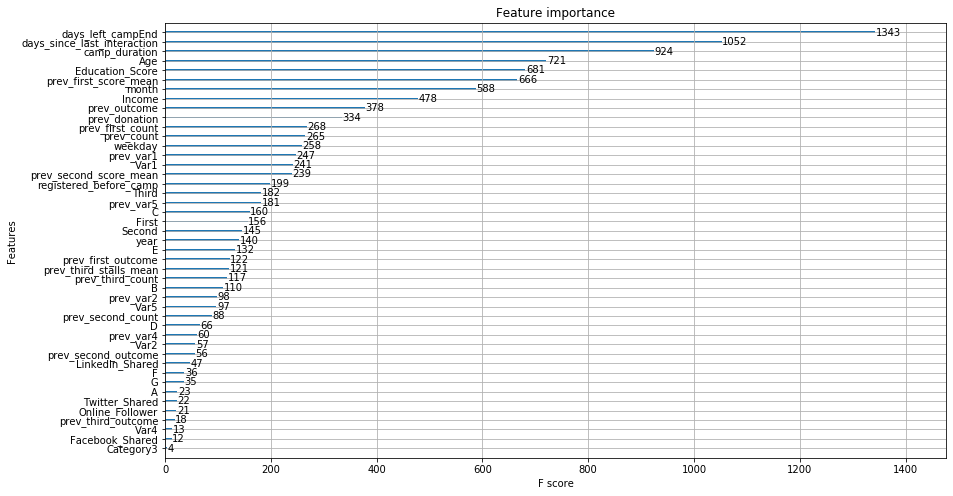

In [96]:
#feature importance
plt.rcParams["figure.figsize"] = (14, 8)
xgb.plot_importance(baseline_model)

In [97]:
gains = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'gain'),'index',columns = ['gain'])
weight = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'weight'),'index',columns = ['weight'])
cover = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'cover'),'index',columns = ['cover'])
total_gains = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'total_gain'),'index',columns = ['total_gains'])
total_cover = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'total_cover'),'index',columns = ['total_cover'])


pd.options.display.max_rows = 100
pd.concat([gains, weight,cover, total_gains,total_cover], axis=1)

,gain,weight,cover,total_gains,total_cover
D,589.654819,66,4098.592198,38917.218026,2.705071e+05
prev_first_score_mean,43.359555,666,938.939456,28877.463595,6.253337e+05
days_left_campEnd,18.855929,1343,634.788705,25323.512016,8.525212e+05
E,34.315590,132,754.682216,4529.657895,9.961805e+04
camp_duration,26.214150,924,1218.776557,24221.874568,1.126150e+06
Income,19.231041,478,878.288755,9192.437715,4.198220e+05
Third,55.316274,182,3150.318932,10067.561914,5.733580e+05
Education_Score,10.510002,681,569.739442,7157.311208,3.879926e+05
prev_donation,23.321124,334,914.825899,7789.255461,3.055519e+05
prev_first_count,7.964912,268,258.521645,2134.596417,6.928380e+04


### Predicted vs Observed

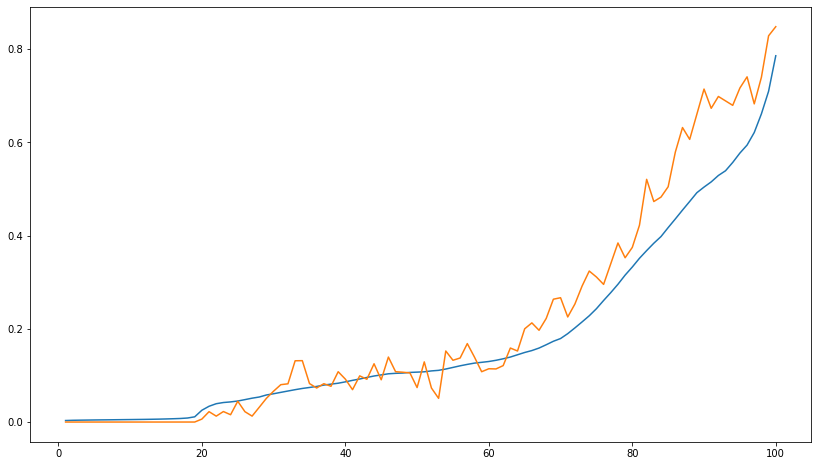

In [98]:
#pvo
def pvo(obs, pred):
    pvo = pd.DataFrame(list(zip(obs,pred)),columns =['observed','predicted']).reset_index()
    pvo['percentile'] = np.ceil(100 * pvo.predicted.rank(ascending =True)/len(pvo.index))
    pvo = pvo.groupby(['percentile'])['observed','predicted'].mean().reset_index()
    plt.plot(pvo.percentile,pvo.predicted, label = 'Predicted')
    plt.plot(pvo.percentile,pvo.observed, label = 'Observed')

#pdp

pvo(Y_validate,preds)

### ROC and AUC

AUC = 0.8671791363983227


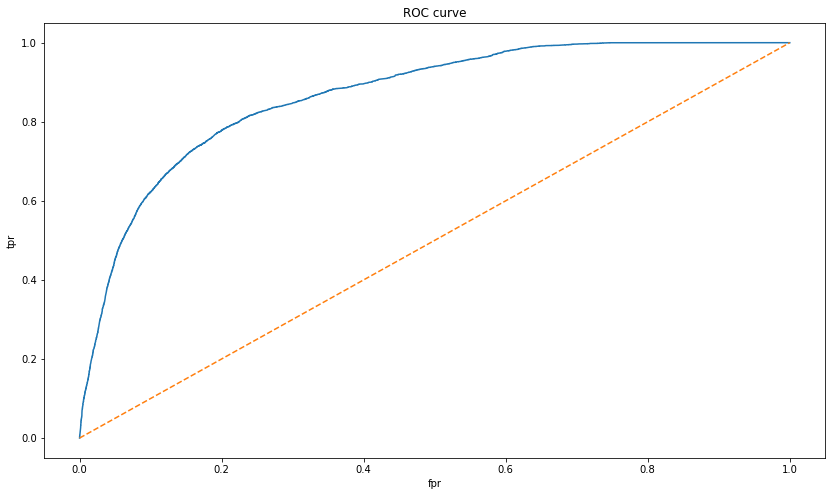

In [99]:
fpr, tpr, thresholds = roc_curve(Y_validate,preds)
print("AUC = " + str(roc_auc_score(Y_validate,preds)))
plt.plot(fpr,tpr, label = 'model')
plt.plot([0,1],[0,1], label = 'random',linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [68]:
# from sklearn.inspection import plot_partial_dependence
# plot_partial_dependence(baseline_model,X_train,features)

### Generate submission 

In [100]:
#retrain on whole data
X_train = train_set.loc[train_set.Camp_Start_Date < '2006-04-01',:].drop(exclusions,axis =1)
Y_train = train_set.loc[train_set.Camp_Start_Date < '2006-04-01','response']



D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(test_set.drop( exclusions,axis=1))

param = {
    'eta': 0.02, 
    'max_depth': 5,  
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
    } 

steps = 300

model = xgb.train(param, D_train, steps)


#score test
submission = test_set.loc[:,['Patient_ID','Health_Camp_ID']]
submission['Outcome'] = model.predict(D_test)
submission.to_csv('submission1.csv',index =False)